# TFL Daily Cicles Hires

## Library imports

In [1]:
import os

import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import scipy

import sklearn
import xgboost as xgb

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
%matplotlib inline

import seaborn as sns

import plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from datetime import datetime as dt
import holidays

In [2]:
print(f'Packages versions:')
print(f'\tnumpy: {np.__version__}')
print(f'\tpandas: {pd.__version__}')
print(f'\tsklearn: {sklearn.__version__}')
print(f'\tstatsmodels: {statsmodels.__version__}')
print(f'\txgboost: {xgb.__version__}')
print(f'\tscipy: {scipy.__version__}')
print(f'\tmatplotlib: {matplotlib.__version__}')
print(f'\tseaborn: {sns.__version__}')
print(f'\tholidays: {holidays.__version__}')

Packages versions:
	numpy: 1.26.4
	pandas: 2.2.2
	sklearn: 1.4.2
	statsmodels: 0.14.1
	xgboost: 2.0.3
	scipy: 1.13.0
	matplotlib: 3.8.4
	seaborn: 0.13.2
	holidays: 0.47


## Parameters

In [3]:
uk_holidays = holidays.country_holidays('GB')
SEASONS = ["Winter", "Spring", "Summer", "Autumn"]

colors = ['#1F77B4', '#FF7F0E', '#CC3363', '#009B72', '#FFE900']

In [4]:
# Cycle hires data
CYCLE_HIRES_EXCEL_SHEET_NAME = 'Data'  # input sheet that contains data

# input columns for main timeseries with daily hires
DATE_TIME_COL = 'Day' 
DAILY_HIRED_BICYCLES_COL = 'Number of Bicycle Hires'

# time features columns
YEAR_COL = 'Year'
SEASON_COL = 'Season'
MONTH_COL = 'Month'
WEEK_COL = 'Week'
DAY_OF_MONTH_COL = 'Day of month'
DAY_OF_YEAR_COL = 'Day of year'
DAY_COL = 'Day'
WEEKDAY_COL = 'Week day'
IS_HOLIDAY_COL = 'is holiday'

# input columns for meta-info with hiring time
MONTHLY_AVG_MONTH_INP_COL = 'Month.1'
AVG_HIRE_TIME_COL = 'Average Hire Time (mins)'

SKIP_ROWS = 5

# Eletrical power data
SETTLEMENT_DATE_COL = 'SD'

## Methods

In [5]:
def get_periodogram(ts, detrend='linear'):
    
    from scipy.signal import periodogram
    
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    
    return frequencies, spectrum

In [6]:
def series_decomposition(series, title, periodo=None):
    """
    Método para decompor séries temporais.
    Exibe os gráficos de suas componentes juntamente com o observável da série.
 
    Args:
        serie (pd.Series): Série temporal a ser analisada.
        periodo (int): Periodicidade da sequência.
    """
 
    decomp = seasonal_decompose(
    x=series,
    model='additive',
    period=365
)
 
    df_decomp = pd.DataFrame(
        {
            'Observed' : decomp.observed,
            'Trend' : decomp.trend,
            'Sazonality' : decomp.seasonal,
            'Noise' : decomp.resid
        }
    )
 
    fig = make_subplots(
        rows=4,
        cols=1,
        specs=[
            [{}],
            [{}],
            [{}],
            [{}],
        ],
        horizontal_spacing=0.03,
        vertical_spacing=0.1,
        shared_xaxes=True,
        shared_yaxes=False,
        subplot_titles=df_decomp.columns
    )
    
    [
        fig.add_trace(
            go.Scatter(
                x=df_decomp.index,
                y=df_decomp[col],
                mode='lines',
                line_color=colors[i],
                name=col,
                
            ),
            row=i + 1,
            col=1,
        )
        for i, col in enumerate(df_decomp.columns)
    ]
    
    fig.update_yaxes(
        showticklabels=True,
        gridcolor='rgba(238, 255, 255, 0.4)',
        showgrid=True,
    )

    fig.update_xaxes(
        linecolor='rgba(238, 255, 255, 1)',
        showticklabels=True,
        linewidth=2,
        showgrid=False,
        showline=True,
    )    
    
    fig.update_layout(
    height=600,
    width=1000,
    
    showlegend=False,
    hovermode='x unified',
    
    title={
        'text': title,
        'xanchor': 'center',
        'x': 0.5,
        'yanchor': 'top',
        'y': 0.99,
        
    },
    
    font_color='rgba(238, 255, 255, 1)',
    margin=dict(l=20, r=20, t=80, b=20),
    
    plot_bgcolor='#263238',
    paper_bgcolor='#263238',
)
    
    fig.show()

In [7]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette('husl', n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f'Seasonal Plot ({period}/{freq})')
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords='offset points',
            size=14,
            va='center',
        )
    return ax

In [8]:
def plot_periodogram(ts, detrend='linear', ax=None):
    
    from scipy.signal import periodogram
    
    fs = pd.Timedelta('365D') / pd.Timedelta('1D')
    
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window='boxcar',
        scaling='spectrum',
    )
    
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color=colors[2])
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            'Annual (1)',
            'Semiannual (2)',
            'Quarterly (4)',
            'Bimonthly (6)',
            'Monthly (12)',
            'Biweekly (26)',
            'Weekly (52)',
            'Semiweekly (104)',
        ],
        rotation=30,
    )
    
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.set_ylabel('Variance')
    ax.set_title('Periodogram')
    
    return ax

In [9]:

def plot_themes():
    color_1 = '#263238'
    color_2 = '#eeffff'

    for param in ['figure.facecolor', 'savefig.facecolor', 'axes.facecolor']:
        plt.rcParams[param] = color_1

    for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color', 'grid.color', 'axes.edgecolor', 'grid.color']:
        plt.rcParams[param] = color_2
        
    plt.rcParams['axes.grid'] = True
    plt.rcParams['axes.grid.which'] = 'both'
    plt.rcParams['grid.linewidth'] = 0.5
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['axes.grid.axis'] = 'y'
    plt.rcParams['axes.axisbelow'] = True

    plt.rcParams['axes.spines.bottom'] = True
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.linewidth'] = 2
    
plot_themes()

## Data

In [10]:
# Data Folder
data_folder = '../data/'

# Data files
file_tfl_cycles_hires = 'tfl-daily-cycle-hires.xlsx'
file_eletrical_power = 'electrical-power-data.csv'

In [11]:
tfl_cycle_hires_path = os.path.join(data_folder, file_tfl_cycles_hires)
electrical_power_path = os.path.join(data_folder, file_eletrical_power)

In [12]:
# Cycles hires data

df_cycle_hires_data_sheet = pd.read_excel(
    tfl_cycle_hires_path,
    sheet_name=CYCLE_HIRES_EXCEL_SHEET_NAME,
    skiprows=SKIP_ROWS,
)

df_daily_hires_history = (
    df_cycle_hires_data_sheet
    [[DAY_COL, DAILY_HIRED_BICYCLES_COL]]
)

df_monthly_avg_hire_time = (
    df_cycle_hires_data_sheet
    [[MONTHLY_AVG_MONTH_INP_COL, AVG_HIRE_TIME_COL]]
    .rename({MONTHLY_AVG_MONTH_INP_COL: MONTH_COL}, axis=1)
    .dropna()
)

In [13]:
# Electrical power data
df_eletrical_power = pd.read_csv(
    electrical_power_path,
    parse_dates=[SETTLEMENT_DATE_COL],
)

for col in df_eletrical_power.columns.drop('SD'):
    df_eletrical_power[col] = df_eletrical_power[col].apply(lambda x: int(x.replace(',', '')))

## Quick EDA

### Hires data overview

- Let's start making an overview of the bycicle hires data.
- A moving average plot will smooth the timeseries preving the random behavior from outliers.

In [14]:
df_daily_hires_history.loc[:, [f'rolling 28d {DAILY_HIRED_BICYCLES_COL}']] = df_daily_hires_history[DAILY_HIRED_BICYCLES_COL].rolling(window=28).mean()

In [15]:
data = df_daily_hires_history

fig = go.Figure()

x = DAY_COL
y = DAILY_HIRED_BICYCLES_COL

fig.add_trace(go.Scatter(
    x=data[x],
    y=data[y],
    mode='lines',
    line=dict(color='#1f77b4', width=2),
    name='Hires'   
))

x = DAY_COL
y = f'rolling 28d {DAILY_HIRED_BICYCLES_COL}'

fig.add_trace(go.Scatter(
    x=data[x],
    y=data[y],
    mode='lines',
    line=dict(color='#ff7f0e', width=2),
    name='28 days average' 
))

fig.update_yaxes(
    title=DAILY_HIRED_BICYCLES_COL,
    showticklabels=True,
    linecolor='rgba(0,0,0,0)',
    gridcolor='rgba(238, 255, 255, 0.4)',
    showgrid=True,
    minor=dict(
        showgrid=True,
        gridcolor='rgba(238, 255, 255, 0.05)'
    )
)

fig.update_xaxes(
    title='Bycicle hires data overview',
    showticklabels=True,
    linecolor='rgba(0,0,0,0)',
    showgrid=False,
)

fig.update_layout(
    height=400,
    width=800,
    
    title={
        'text': '',
        'xanchor': 'center',
        'x': 0.5,
        'yanchor': 'top',
        'y': 0.99,
        
    },
    
    legend={
        'title' : '',
        #'orientation': 'h',
        'yanchor': 'top',
        'y': 0.92,
        'xanchor': 'left',
        'x': 0.01,
        'bgcolor' : 'rgba(238, 255, 255, 0.1)',
        'bordercolor': 'rgba(238, 255, 255, 5)',
        #'borderwidth': 1,
    },
    font_color='rgba(238, 255, 255, 1)',
    margin=dict(l=10, r=10, t=20, b=20),
    
    plot_bgcolor='#263238',
    paper_bgcolor='#263238',
)

fig.show()

- There is a clear trend on the plot.
- Some peaks in 2015 and 2020.

In order to analise the sazonalitie we need to create time features for the time series, also adding the UK holidays.

In [16]:
df_daily_hires_history[YEAR_COL] = df_daily_hires_history[DAY_COL].dt.year
df_daily_hires_history.loc[:, [SEASON_COL]] = df_daily_hires_history[DAY_COL].apply(lambda row: row.month % 12 // 3)
df_daily_hires_history[MONTH_COL] = df_daily_hires_history[DAY_COL].dt.month
df_daily_hires_history[WEEK_COL] = df_daily_hires_history[DAY_COL].dt.isocalendar().week
df_daily_hires_history[DAY_OF_MONTH_COL] = df_daily_hires_history[DAY_COL].dt.day
df_daily_hires_history[DAY_OF_YEAR_COL] = df_daily_hires_history[DAY_COL].dt.dayofyear
df_daily_hires_history[WEEKDAY_COL] = df_daily_hires_history[DAY_COL].dt.dayofweek

df_daily_hires_history.loc[:, [IS_HOLIDAY_COL]] = df_daily_hires_history[DAY_COL].apply(lambda row: row in uk_holidays)

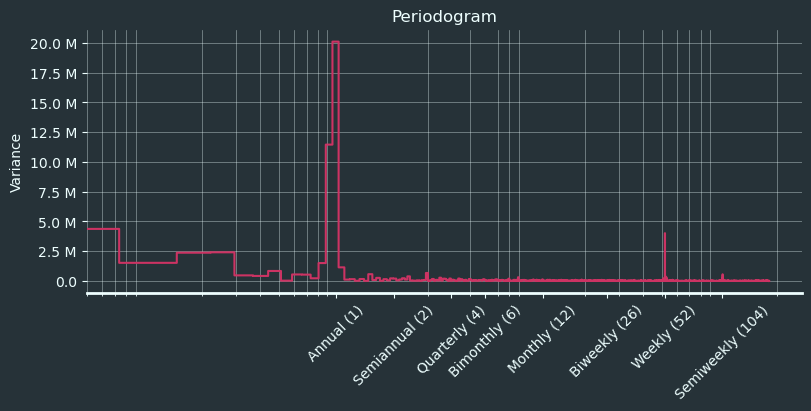

In [17]:
fig, ax = plt.subplots(
    constrained_layout=True,
    figsize=(8, 4)
)

plot_periodogram(df_daily_hires_history[DAILY_HIRED_BICYCLES_COL], ax=ax)

formatter_y = mticker.EngFormatter(places=1)
ax.yaxis.set_major_formatter(formatter_y)

# X-axis date format
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='center')

plt.show()

- The periodogram shows strong annual seasonality and considerable weekly seasonality.
- Let's check these indications of periodic effects on a seasonal graph.

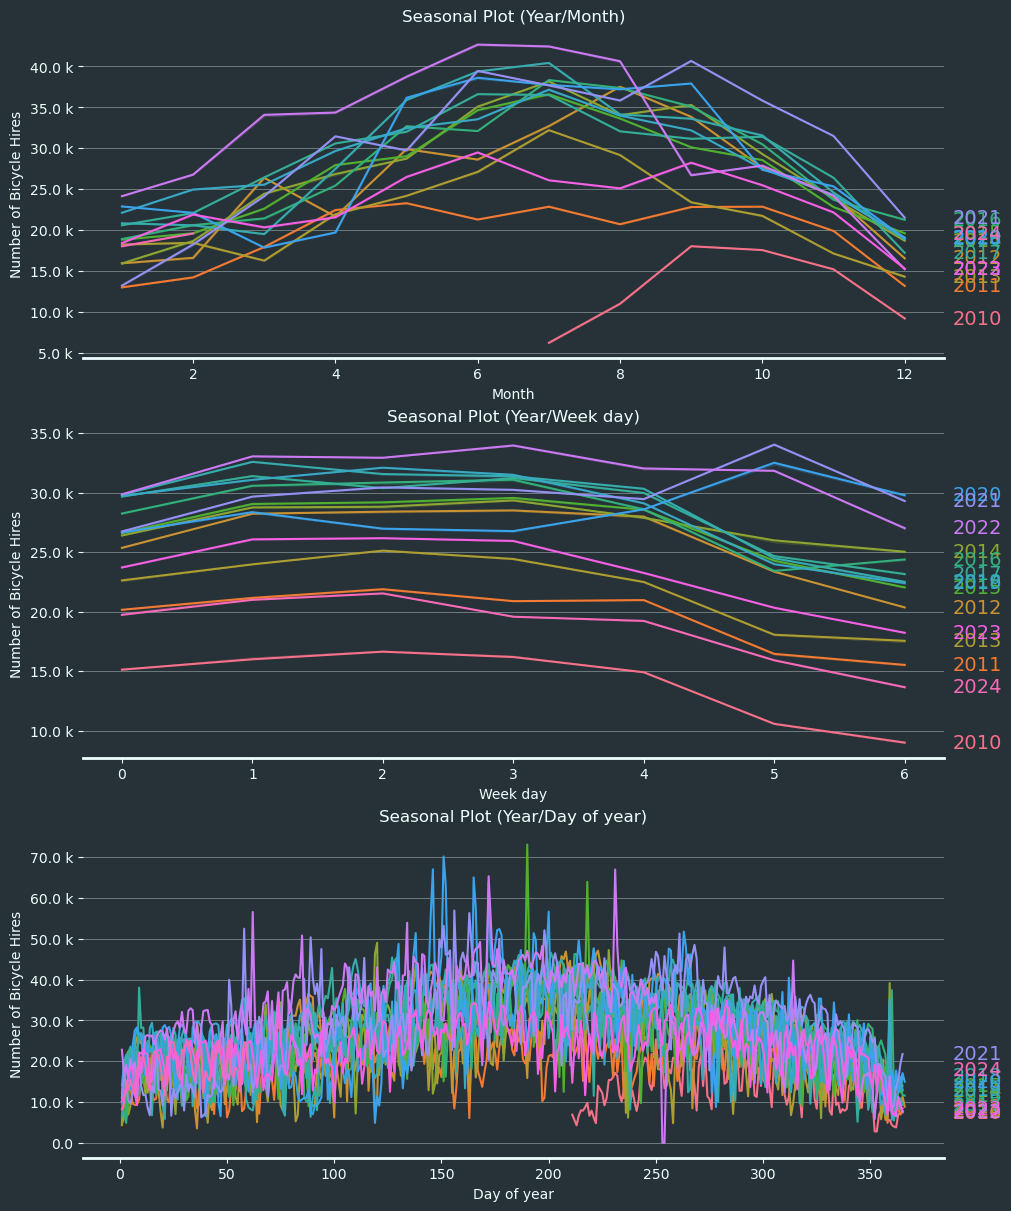

In [18]:
nrows = 3

fig, ax = plt.subplots(
    nrows=nrows,
    ncols=1,
    sharey=False,
    sharex=False,
    constrained_layout=True,
    figsize=(10, 4 * nrows)
)

seasonal_plot(X=df_daily_hires_history, y=DAILY_HIRED_BICYCLES_COL, period=YEAR_COL, freq=MONTH_COL, ax=ax[0])
seasonal_plot(X=df_daily_hires_history, y=DAILY_HIRED_BICYCLES_COL, period=YEAR_COL, freq=WEEKDAY_COL, ax=ax[1])
seasonal_plot(X=df_daily_hires_history, y=DAILY_HIRED_BICYCLES_COL, period=YEAR_COL, freq=DAY_OF_YEAR_COL, ax=ax[2])

formatter_y = mticker.EngFormatter(places=1)
for i in range(3):
    ax[i].yaxis.set_major_formatter(formatter_y)

# X-axis date format
#for label in ax[0].get_xticklabels(which='major'):
#    label.set(rotation=45, horizontalalignment='center')

plt.show()

- The first sazonal plot shows the month over year hires with peaks during the summer months.
- The second plot for the dependency of dayofweek over the years shows that the number of hires is lower during the weekends.
- After COVID-19 the hires of bicycles increased during the weekends.

In [19]:
series_decomposition(
    df_daily_hires_history[[DAY_COL, DAILY_HIRED_BICYCLES_COL]].set_index(DAY_COL)[DAILY_HIRED_BICYCLES_COL],
    title='Bycicle hires series decomposition',
    periodo=365
)

- There is an additive sazonal component with a peak during the summer months.
- The sazonal plot is for a period of 365 days, but there is effect of a weekly sazonal period.
- The trend is growing in the first few years due to the implementation of the bike hire system with opening of new stations.
- After 2014 the trend shows a more constant behaviour.

In [20]:
(
    df_daily_hires_history
    .sort_values(DAILY_HIRED_BICYCLES_COL, ascending=False)
    .head(10)
    [[DAY_COL, WEEKDAY_COL, IS_HOLIDAY_COL, MONTH_COL]]
)

Day  Week day  is holiday  Month
1805 2015-07-09         3       False      7
3592 2020-05-30         5       False      5
3587 2020-05-25         0        True      5
4403 2022-08-19         4       False      8
4344 2022-06-21         1       False      6
3606 2020-06-13         5       False      6
3613 2020-06-20         5       False      6
1833 2015-08-06         3       False      8
3593 2020-05-31         6       False      5
3607 2020-06-14         6       False      6

In [44]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq='YE', order=2)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=df_daily_hires_history[DATE_TIME_COL],
    constant=True,               # dummy feature for bias (y-intercept)
    order=2,                     # trend (order 1 means linear)
    #seasonal=True,               # weekly seasonality (indicators)
    #additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()
X.head()

const  trend  trend_squared
Day                                    
2010-07-30    1.0    1.0            1.0
2010-07-31    1.0    2.0            4.0
2010-08-01    1.0    3.0            9.0
2010-08-02    1.0    4.0           16.0
2010-08-03    1.0    5.0           25.0

<Axes: xlabel='Day'>

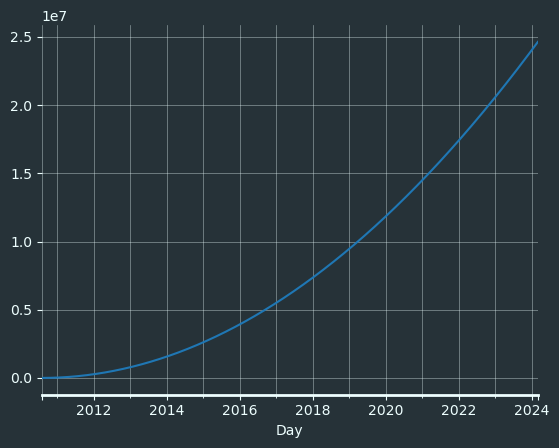

In [45]:
X['trend_squared'].plot()

In [ ]:
from statsmodels.tsa.deterministic